In [1]:
from llvmlite import ir

Build a simple function with a for loop that sum the first N integer, where N is the argument.

In [2]:
m = ir.Module()

In [3]:
fnty = ir.FunctionType(ir.IntType(32), [ir.IntType(32)])
print(fnty)

i32 (i32)


In [4]:
fn = ir.Function(m, fnty, "count_number")
fn.args[0].name= 'N'
print(fn)

declare i32 @"count_number"(i32 %"N") 



In [5]:
builder = ir.IRBuilder(fn.append_basic_block('entry'))

Initialize variable `ct` and `out` with `0`

In [6]:
out = builder.alloca(ir.IntType(32), name='out')
ct = builder.alloca(ir.IntType(32), name='ct')
builder.store(out.type.pointee(0), out)
builder.store(ct.type.pointee(0), ct)
print(fn)

define i32 @"count_number"(i32 %"N") 
{
entry:
  %"out" = alloca i32
  %"ct" = alloca i32
  store i32 0, i32* %"out"
  store i32 0, i32* %"ct"
}



Populate loop header

In [7]:
loophead = fn.append_basic_block('loop.header')
loopbody = fn.append_basic_block('loop.body')
loopend = fn.append_basic_block('loop.end')

builder.branch(loophead)
builder.position_at_end(loophead)

# loop if ct < arg0
arg0 = fn.args[0]
pred = builder.icmp_signed('<', builder.load(ct), arg0)
builder.cbranch(pred, loopbody, loopend)

print(fn)

define i32 @"count_number"(i32 %"N") 
{
entry:
  %"out" = alloca i32
  %"ct" = alloca i32
  store i32 0, i32* %"out"
  store i32 0, i32* %"ct"
  br label %"loop.header"
loop.header:
  %".6" = load i32, i32* %"ct"
  %".7" = icmp slt i32 %".6", %"N"
  br i1 %".7", label %"loop.body", label %"loop.end"
loop.body:
loop.end:
}



Populate loop body

In [8]:
builder.position_at_end(loopbody)

# out += ct
builder.store(builder.add(builder.load(out), builder.load(ct)), out)
# ct += 1
builder.store(builder.add(builder.load(ct), ct.type.pointee(1)), ct)
# jump to loophead
builder.branch(loophead)

print(fn)

define i32 @"count_number"(i32 %"N") 
{
entry:
  %"out" = alloca i32
  %"ct" = alloca i32
  store i32 0, i32* %"out"
  store i32 0, i32* %"ct"
  br label %"loop.header"
loop.header:
  %".6" = load i32, i32* %"ct"
  %".7" = icmp slt i32 %".6", %"N"
  br i1 %".7", label %"loop.body", label %"loop.end"
loop.body:
  %".9" = load i32, i32* %"out"
  %".10" = load i32, i32* %"ct"
  %".11" = add i32 %".9", %".10"
  store i32 %".11", i32* %"out"
  %".13" = load i32, i32* %"ct"
  %".14" = add i32 %".13", 1
  store i32 %".14", i32* %"ct"
  br label %"loop.header"
loop.end:
}



Populate loop end

In [9]:
builder.position_at_end(loopend)

builder.ret(builder.load(out))

print(fn)

define i32 @"count_number"(i32 %"N") 
{
entry:
  %"out" = alloca i32
  %"ct" = alloca i32
  store i32 0, i32* %"out"
  store i32 0, i32* %"ct"
  br label %"loop.header"
loop.header:
  %".6" = load i32, i32* %"ct"
  %".7" = icmp slt i32 %".6", %"N"
  br i1 %".7", label %"loop.body", label %"loop.end"
loop.body:
  %".9" = load i32, i32* %"out"
  %".10" = load i32, i32* %"ct"
  %".11" = add i32 %".9", %".10"
  store i32 %".11", i32* %"out"
  %".13" = load i32, i32* %"ct"
  %".14" = add i32 %".13", 1
  store i32 %".14", i32* %"ct"
  br label %"loop.header"
loop.end:
  %".17" = load i32, i32* %"out"
  ret i32 %".17"
}



Visualize CFG

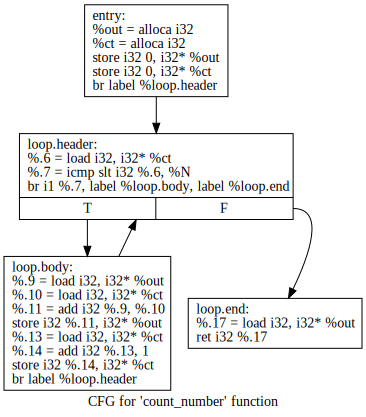

In [10]:
from llvmlite import binding as llvm

dot = llvm.get_function_cfg(fn)
llvm.view_dot_graph(dot)

Optimize the function

In [11]:
# materialize a LLVM module
mod = llvm.parse_assembly(str(m))

# create optimizer
pm = llvm.create_module_pass_manager()
pmb = llvm.create_pass_manager_builder()
pmb.opt_level = 3  # -O3
pmb.populate(pm)

# optimize
pm.run(mod)

print(mod)

; ModuleID = '<string>'
target triple = "unknown-unknown-unknown"

; Function Attrs: norecurse nounwind readnone
define i32 @count_number(i32 %N) #0 {
entry:
  %.71 = icmp sgt i32 %N, 0
  br i1 %.71, label %loop.body.preheader, label %loop.end

loop.body.preheader:                              ; preds = %entry
  %0 = add i32 %N, -1
  %1 = zext i32 %0 to i33
  %2 = add i32 %N, -2
  %3 = zext i32 %2 to i33
  %4 = mul i33 %1, %3
  %5 = lshr i33 %4, 1
  %6 = trunc i33 %5 to i32
  %7 = add i32 %6, %N
  %8 = add i32 %7, -1
  br label %loop.end

loop.end:                                         ; preds = %loop.body.preheader, %entry
  %out.0.lcssa = phi i32 [ 0, %entry ], [ %8, %loop.body.preheader ]
  ret i32 %out.0.lcssa
}

attributes #0 = { norecurse nounwind readnone }



View optimized CFG

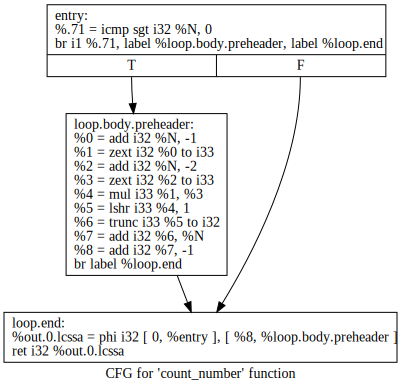

In [12]:
dot = llvm.get_function_cfg(mod.get_function(fn.name))
llvm.view_dot_graph(dot)

Notice LLVM has optimized the looping away.